# E-commerce Customer Churn Prediction

## Project Info

This project seeks to create a prediction model for e-commerce customer churn. This is a supervised learning project because the data notes which customers churned (by the time of data collection). Both inference and prediction will be helpful, so that is the goal of this project.

This project uses a dataset from Kaggle, so my analysis will not have real-world analysis. However, I picked this dataset because I am a product analyst for a payments platform that services e-commerce payments. Consequently, this project will help me make a similar prediction model for my company. Churn prediction is useful in Product because an accurate prediction model allows the company to target treatment efforts to reduce churn, such as offering discounts, having a company representative contact the customer, and so on.

The dataset is publicly available and can be found here: https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction/data

The dataset is tabular and contains about 5600 observations where each observation is a unique customer. The file size is only 556 KB.

The data contains:
- 1 ID column
- 1 Target column
- 18 Feature columns: 11 continuous and 7 categorical that will later be assigned as continous_cols and categorical_cols

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer, SimpleImputer
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, make_scorer, recall_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.proportion import proportions_ztest



warnings.filterwarnings("ignore")

In [2]:
data_definitions = pd.read_excel("./E Commerce Dataset.xlsx", header = 1) 
data_definitions = data_definitions.drop(data_definitions.columns[0:2], axis =1 )
data_definitions = data_definitions.rename(columns={"Discerption": "Description"})
data_definitions

,Variable,Description
0,CustomerID,Unique customer ID
1,Churn,Churn Flag
2,Tenure,Tenure of customer in organization
3,PreferredLoginDevice,Preferred login device of customer
4,CityTier,City tier
5,WarehouseToHome,Distance in between warehouse to home of customer
6,PreferredPaymentMode,Preferred payment method of customer
7,Gender,Gender of customer
8,HourSpendOnApp,Number of hours spend on mobile application or...
9,NumberOfDeviceRegistered,Total number of deceives is registered on part...


In [3]:
data = pd.read_excel("./E Commerce Dataset.xlsx", sheet_name = "E Comm")

In [4]:
df = data.copy(deep=True)
df.set_index('CustomerID', inplace=True)
df.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
CustomerID,,,,,,,,,,,,,,,,,,,
50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


## Data Exploration

In [5]:
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

The percent of data that is churners: 16.8%


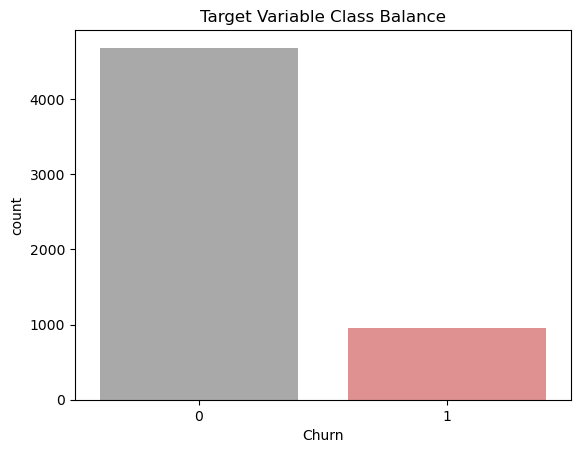

In [6]:
print("The percent of data that is churners: {:.1%}".format(df[df['Churn']==1]['Churn'].count()   /   len(df)))
sns.countplot(data=df, x='Churn', palette= {'0': 'darkgray', '1': 'lightcoral'}, saturation = .7)
plt.title("Target Variable Class Balance")
plt.show()

This target variable is unbalanced at a ratio of about 1 churner to 5 non-churners, so feature selection and model selection and tuning should take this into consideration.

In [7]:
continuous_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_cols = []
for col in df.columns:
    if col not in continuous_cols:
        categorical_cols.append(col)
assert set(categorical_cols + continuous_cols) == set(df.columns), "There are uncategorized columns."
categorical_cols.remove('Churn')

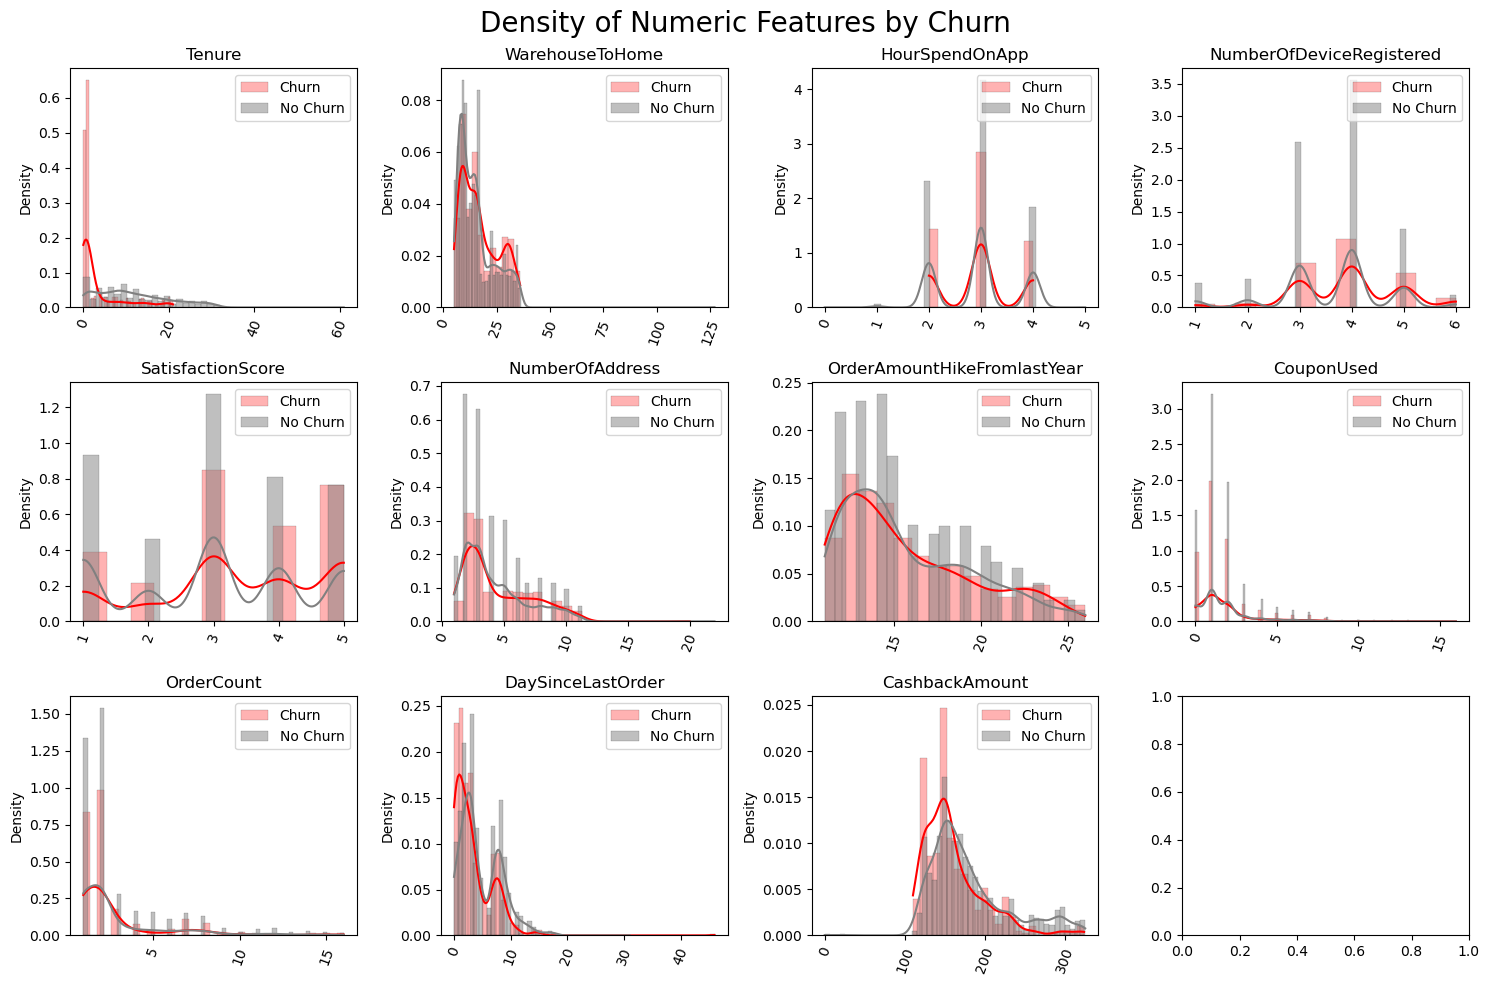

In [8]:
def plot_stacked_histograms(df, cols, graphs_per_line, kde):
    churn_df = df[df['Churn'] == 1].copy()
    no_churn_df = df[df['Churn'] == 0].copy()

    num_cols = len(cols)
    num_rows = (num_cols + graphs_per_line - 1) // graphs_per_line 

    fig, ax = plt.subplots(num_rows, graphs_per_line, figsize=(15, 10))
    fig.suptitle('Density of Numeric Features by Churn', fontsize=20)

    if num_rows == 1:
        ax = ax[np.newaxis, :]  # ensure ax is 2D even if there's only one row

    for idx, c in enumerate(cols):
        row_idx = idx // graphs_per_line  # row index
        col_idx = idx % graphs_per_line  # column index

        sns.histplot(churn_df[c], kde=kde, linewidth=.1, label='Churn', ax=ax[row_idx, col_idx], alpha=0.3, stat='density', color = 'red')
        sns.histplot(no_churn_df[c], kde=kde, linewidth=.1, label='No Churn', ax=ax[row_idx, col_idx], alpha=0.5, stat='density', color = 'gray')
        ax[row_idx, col_idx].legend(loc='upper right')
        ax[row_idx, col_idx].set_title(c)
        ax[row_idx, col_idx].set_xticklabels(ax[row_idx, col_idx].get_xticklabels(), rotation=70, ha='center')
        ax[row_idx, col_idx].set_xlabel('')


    plt.tight_layout()
    plt.show()

plot_stacked_histograms(df, continuous_cols, 4, True)

Continuous columns that appear to be most divergent between churned and did-not-churn groups:
- Tenure: Lower tenure correlates with higher churn
- DaysSinceLastOrder: Less time since the last order correlates with higher churn. Seems counterintuitive, could be due to promotions or trial periods.
- CashbackAmount: Lower cashback amount correlates with higher churn.

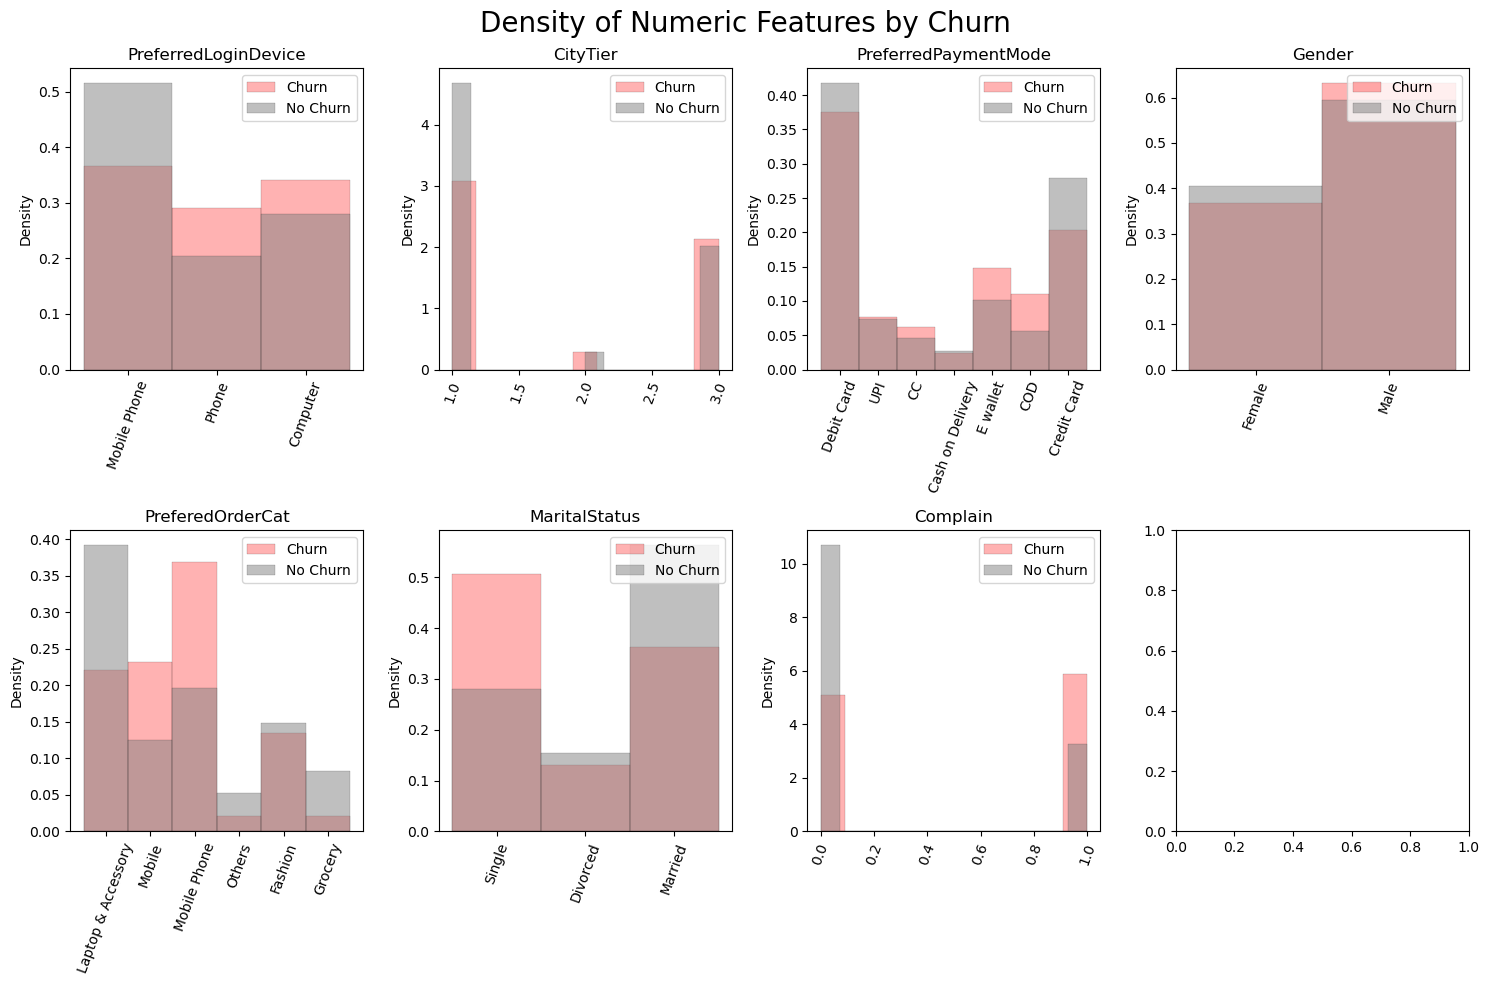

In [9]:
categorical_cols_filtered = [col for col in categorical_cols if col not in ['Churn', 'CustomerID']]
plot_stacked_histograms(df, categorical_cols_filtered, 4, False)

Categorical columns that appear to be most divergent between churned and non-churn groups:
- Complain: Having a complaint correlates with higher churn
- PreferedOrderCat: The mobile has a higher churn and the laptop category has a lower churn 
- MaritalStatus: Being single correlates with higher churn

In [10]:
no_nulls_df = df.dropna(inplace = False)

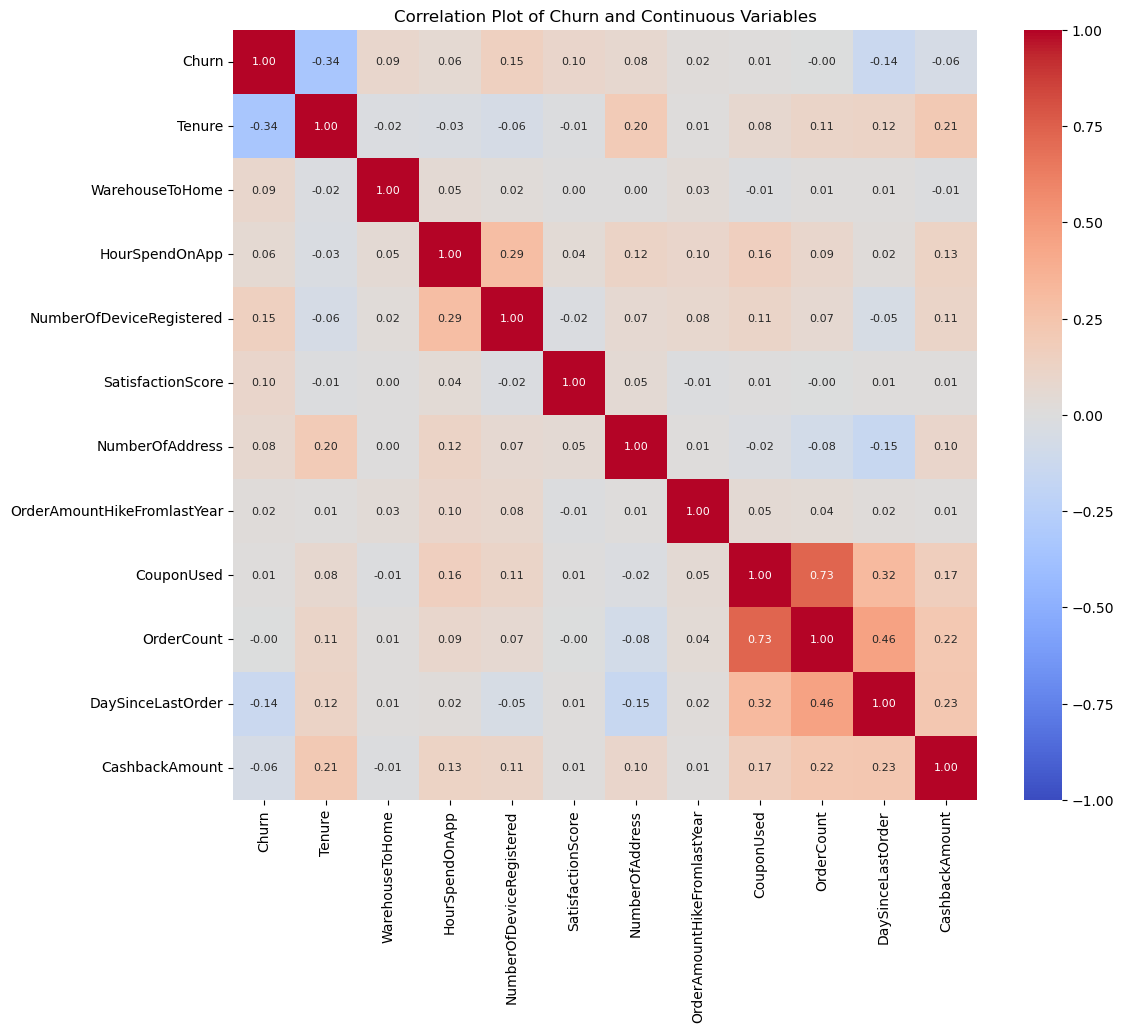

In [11]:
corr_cols = ['Churn'] + continuous_cols
corr_matrix = no_nulls_df[corr_cols].corr()
plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix,
            annot=True, vmin= -1, vmax = 1, cmap='coolwarm', fmt = '.2f',
            annot_kws={"fontsize": 8, "ha": 'center', "va": 'center'})
plt.title("Correlation Plot of Churn and Continuous Variables")
plt.show()

Correlation Findings:

- Tenure is the feature most correlated with churn at 0.34. This is super interesting because this signals that longer tenure means higher churn, this is counterintuitive because one would expect more loyal customers to have longer tenure. 

- CouponUsed and OrderCount have the highest pairwise correlation at 0.73. This is not big enough to cause multicollinearity issues nor is there a lot of features relative to observations, so there is no strong reason to remove features from this model.

- Cashback amount is the most correlated with other features in the model, but it doesn't appear egregious. 

- Overall, there is not much correlation between the features and churn.


In [12]:
cont_matrix = no_nulls_df[continuous_cols]
vif = [variance_inflation_factor(cont_matrix.values, i) for i in range(cont_matrix.shape[1])]
print("Variance Inflation Factors (VIF):")
for i, feature in enumerate(cont_matrix.columns):
    print(f"{feature}: {vif[i]:.2f}")

Variance Inflation Factors (VIF):
Tenure: 2.57
WarehouseToHome: 4.25
HourSpendOnApp: 19.73
NumberOfDeviceRegistered: 15.55
SatisfactionScore: 5.58
NumberOfAddress: 4.11
OrderAmountHikeFromlastYear: 16.61
CouponUsed: 4.54
OrderCount: 5.75
DaySinceLastOrder: 3.76
CashbackAmount: 32.34


Using the rule of thumb that a VIF > 10 is concerning, 4 features are concerning, and will need to be addressed during feature selection. In descending order of VIF:
1) CashbackAmount
2) HoursSpendOnApp
3) OrderAmountHikeFromlastYear
4) NumberOfDeviceRegistered

## Data Cleaning

### Handling Nulls

In [13]:
pd.isnull(df).sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [14]:
rows_with_null = df.isnull().any(axis=1).sum()
null_values = pd.isnull(df).sum().sum()
print("There are {} rows with nulls and {} total null values.".format(rows_with_null, null_values))

There are 1856 rows with nulls and 1856 total null values.


In [15]:
print("There are {} rows of data and {} of them have nulls. That means {:.2f}% of rows have nulls. So, we can't just delete every row with a null. However, there is no overlap with null values. Each row has at most one null value.".format(
    len(data), rows_with_null, rows_with_null/len(data)*100))

There are 5630 rows of data and 1856 of them have nulls. That means 32.97% of rows have nulls. So, we can't just delete every row with a null. However, there is no overlap with null values. Each row has at most one null value.


In [16]:
null_df = data[data.isnull().any(axis=1)] #make a df of rows with a null value

In [17]:
rows_with_multiple_nulls = null_df[null_df.isnull().sum(axis=1) > 1]
print(rows_with_multiple_nulls)

Empty DataFrame
Columns: [CustomerID, Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []


There are no rows that have more than 1 missing value.

#### Tenure, HourSpendOnApp, OrderAmountHikeFromlastYear

In [18]:
print(df['Tenure'].unique())

[ 4. nan  0. 13. 11.  9. 19. 20. 14.  8. 18.  5.  2. 30.  1. 23.  3. 29.
  6. 26. 28.  7. 24. 25. 10. 15. 22. 27. 16. 12. 21. 17. 50. 60. 31. 51.
 61.]


0 is an existing value so null probably doesn't mean tenure = 0

In [19]:
print(df['HourSpendOnApp'].unique())

[ 3.  2. nan  1.  0.  4.  5.]


0 is an existing value so null probably doesn't mean tenure = 0

In [20]:
print(df['OrderAmountHikeFromlastYear'].unique()) 

[11. 15. 14. 23. 22. 16. 12. nan 13. 17. 18. 24. 19. 20. 21. 25. 26.]


0 is not an existing value, at first I thought that this meant that they did not purchase again, however many of these null rows did not churn, meaning many of them DID have a previous order amount to calculate this field on.

**All of the other null values in the other columns are inexplicably missing from the dataset.**

### Null AA Tests

Without additional context, I am unable to diagnose why there are nulls. However, due to there never being more than one null in a given row, the null values are perfectly correlated in that if one null value is observed there is 100% probability that it is the only one. I will conduct AB tests for each kind of null group (Tenure null rows, HoursSpendOnApp null rows, etc.) vs No Nulls rows to see if there is a statistical difference between the null groups' churn rates and the non-null group.

In [21]:
cols_with_null = df.columns[df.isnull().any()].tolist()
print("Columns with null values:", cols_with_null)

Columns with null values: ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']


In [22]:
no_nulls_df_row_count = len(no_nulls_df)
no_nulls_df_churn_count = no_nulls_df['Churn'].sum()
no_nulls_df_churn_percent = no_nulls_df_churn_count/no_nulls_df_row_count

In [23]:
class AB_test_df:
    '''
    Class that creates a df by filtering to get rows with nulls for the column of interest, the resulting dataframe will be callable as well as its number of rows and churns and churn rate.
    '''
    def __init__(self, original_df, col_of_interest):
        self.df = self.create_null_group_df(original_df, col_of_interest)
        self.churn_count = self.df['Churn'].sum()
        self.row_count = len(self.df)
        self.churn_percent = self.churn_count/self.row_count

    def create_null_group_df(self, original_df, col_of_interest):
        df = original_df[original_df[col_of_interest].isnull()]
        return df

    def __call__(self):
        return self.df

null_group_dfs = {}
for col in cols_with_null:
    class_name = col
    null_group_dfs[col] = AB_test_df(df, col)



In [24]:
test_results = []
for col in cols_with_null:
    statistic, p_value = proportions_ztest([null_group_dfs[col].churn_count, no_nulls_df_churn_count], [null_group_dfs[col].row_count, no_nulls_df_row_count], alternative = 'two-sided')
    test_results.append({'Column': col, 'Statistic': statistic, 'P-value': p_value, 'Churn Propotion': null_group_dfs[col].churn_percent})

test_results_df = pd.DataFrame(test_results).sort_values(by='Statistic')
test_results_df = test_results_df.round(4)
print(f"The benchmark, churn proportion for the non-null observations, is: {no_nulls_df_churn_percent:.4f}")
test_results_df

The benchmark, churn proportion for the non-null observations, is: 0.1672


,Column,Statistic,P-value,Churn Propotion
4,CouponUsed,-5.7627,0.0000,0.0312
3,OrderAmountHikeFromlastYear,-4.9127,0.0000,0.0528
5,OrderCount,-4.1199,0.0000,0.0698
6,DaySinceLastOrder,0.3922,0.6949,0.1759
2,HourSpendOnApp,2.4733,0.0134,0.2275
0,Tenure,5.7549,0.0000,0.3068
1,WarehouseToHome,6.7217,0.0000,0.3347


All but one of these null groups, 'DaysSinceLastOrder', are statistically significant at the traditional 95% level. So, the null groups seem to be meaningfully different from the non-null observations; half have higher churn rates and the other half have lower churn rates.

Normally, given these drastic differences, I would look further into the sources of the data to understand where the nulls are coming from because they are very meaningful. For example, I can almost guarantee that a customer with a null value for 'CouponUsed' did not attrit (3.1% churn rate). So, if a null presence here means that they were offered some other treatment that was not a coupon, like a loyalty program discount, then I would explore expanding the loyalty program.

Again, since I cannot know why the nulls exist and all of these groups are continuous, I will be imputing values for 'DaysSinceLastOrder' as it was not statistically different and will be dropping all rows from the statistically significant null groups. I will use that no-nulls data frame for any models that cannot handle nulls.

### Imputing DaysSinceLastOrder nulls and removing all other nulls

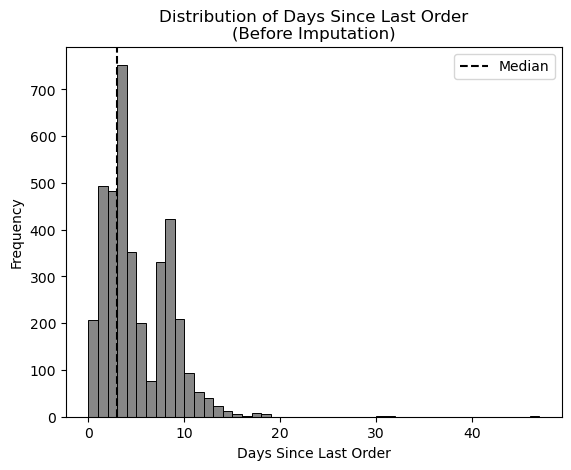

In [25]:
#show no nulls df before imputing
plot_data = no_nulls_df['DaySinceLastOrder']
bins = range(int(plot_data.min()), int(plot_data.max()) + 2)  # Set bins to be width 1
sns.histplot(plot_data, bins = bins, color = 'dimgray', alpha = .8)
plt.axvline(x = plot_data.median(), color = 'black', linestyle = '--', label="Median")
plt.title("Distribution of Days Since Last Order\n(Before Imputation)")
plt.xlabel("Days Since Last Order")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Because the data for this column is not normally distributed or symmetrics, imputing using mean or median should be avoided. I will instead use KNN imputation.

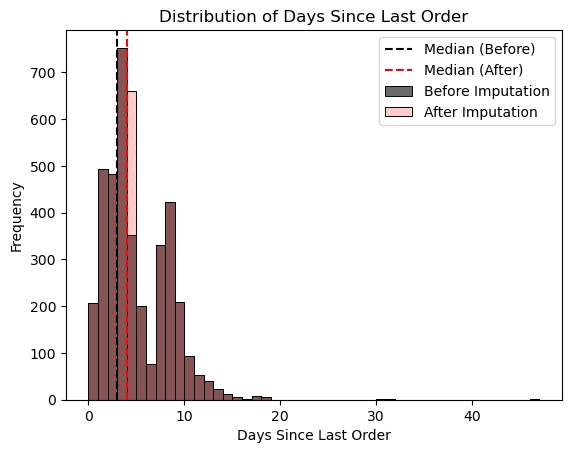

In [26]:
# Drop rows with NaN values EXCEPT for those with NaN in 'DaySinceLastOrder' column
plot_data_before = no_nulls_df['DaySinceLastOrder']


# Impute the data
no_nulls_imp_df = df.dropna(subset=df.columns.difference(['DaySinceLastOrder']), inplace=False) # Note this has not been imputed yet, to be imputed
col_to_impute = no_nulls_imp_df[['DaySinceLastOrder']]
imputer = KNNImputer(n_neighbors = 3)
imputed_col = imputer.fit_transform(col_to_impute)
no_nulls_imp_df['DaySinceLastOrder'] = imputed_col
assert no_nulls_imp_df.isnull().sum().sum() == 0, "df contains null values"


plot_data_after = no_nulls_imp_df['DaySinceLastOrder']


# Plot the data
bins = range(int(min(plot_data_before.min(), plot_data_after.min())), int(max(plot_data_before.max(), plot_data_after.max())) + 2)
sns.histplot(plot_data_before, bins=bins, alpha=1, label="Before Imputation", color = 'dimgray')
sns.histplot(plot_data_after, bins=bins, alpha=0.2, label="After Imputation", color = 'red')

# Add median lines
plt.axvline(x=plot_data_before.median(), color='black', linestyle='--', label="Median (Before)")
plt.axvline(x=plot_data_after.median(), color='red', linestyle='--', label="Median (After)")

# Customize the plot
plt.title("Distribution of Days Since Last Order")
plt.xlabel("Days Since Last Order")
plt.ylabel("Frequency")
plt.legend()
plt.show()


The imputer gives all the imputations the same value (the median + 1), slightly shifting the distribution to the right (where it is skewed). This result occured regardless of how many nearest neighbors I chose: 2,3,4, even 10. This suggests that these null values are very closely related with another feature. I know from the correlation matrix that it is moderately correlated with OrderCount but having all imputations be the same is rather extreme. So, I am going to check if DaySinceLastOrder is very correlated with any of the categorical variables.

I will run an ANOVA to test if it does have a statistically significant relationship with any of the categorical variables.

                          df        sum_sq     mean_sq          F  \
PreferredLoginDevice     2.0    780.099842  390.049921  40.116887   
PreferredPaymentMode     6.0    190.368903   31.728150   3.263261   
Gender                   1.0     10.779109   10.779109   1.108638   
PreferedOrderCat         5.0   2177.672771  435.534554  44.795011   
MaritalStatus            2.0      8.778698    4.389349   0.451447   
CityTier                 1.0    115.380282  115.380282  11.866937   
Complain                 1.0    105.662436  105.662436  10.867450   
Residual              4062.0  39494.160980    9.722836        NaN   

                            PR(>F)  
PreferredLoginDevice  5.588461e-18  
PreferredPaymentMode  3.339592e-03  
Gender                2.924408e-01  
PreferedOrderCat      3.795900e-45  
MaritalStatus         6.367379e-01  
CityTier              5.771780e-04  
Complain              9.871028e-04  
Residual                       NaN  


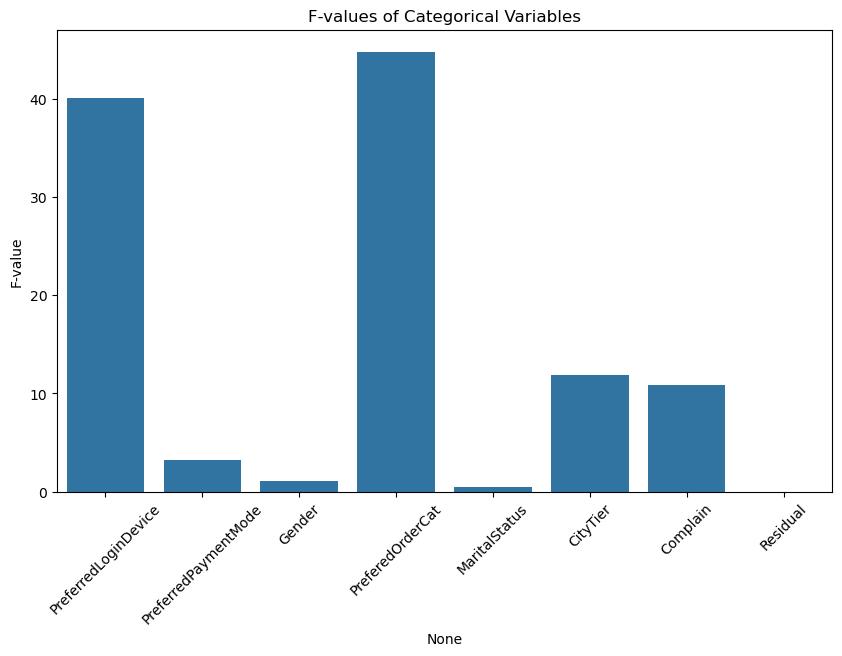

In [27]:
formula = 'DaySinceLastOrder ~ ' + ' + '.join(categorical_cols)
model = smf.ols(formula, no_nulls_imp_df).fit()
anova_table = anova_lm(model)  # Use anova_lm from statsmodels.stats.anova

print(anova_table)
plt.figure(figsize=(10, 6))
sns.barplot(x=anova_table.index, y='F', data=anova_table)
plt.title('F-values of Categorical Variables')
plt.ylabel('F-value')
plt.xticks(rotation=45)
plt.show()

Examining the relationships with categorical variables deserves further examination.

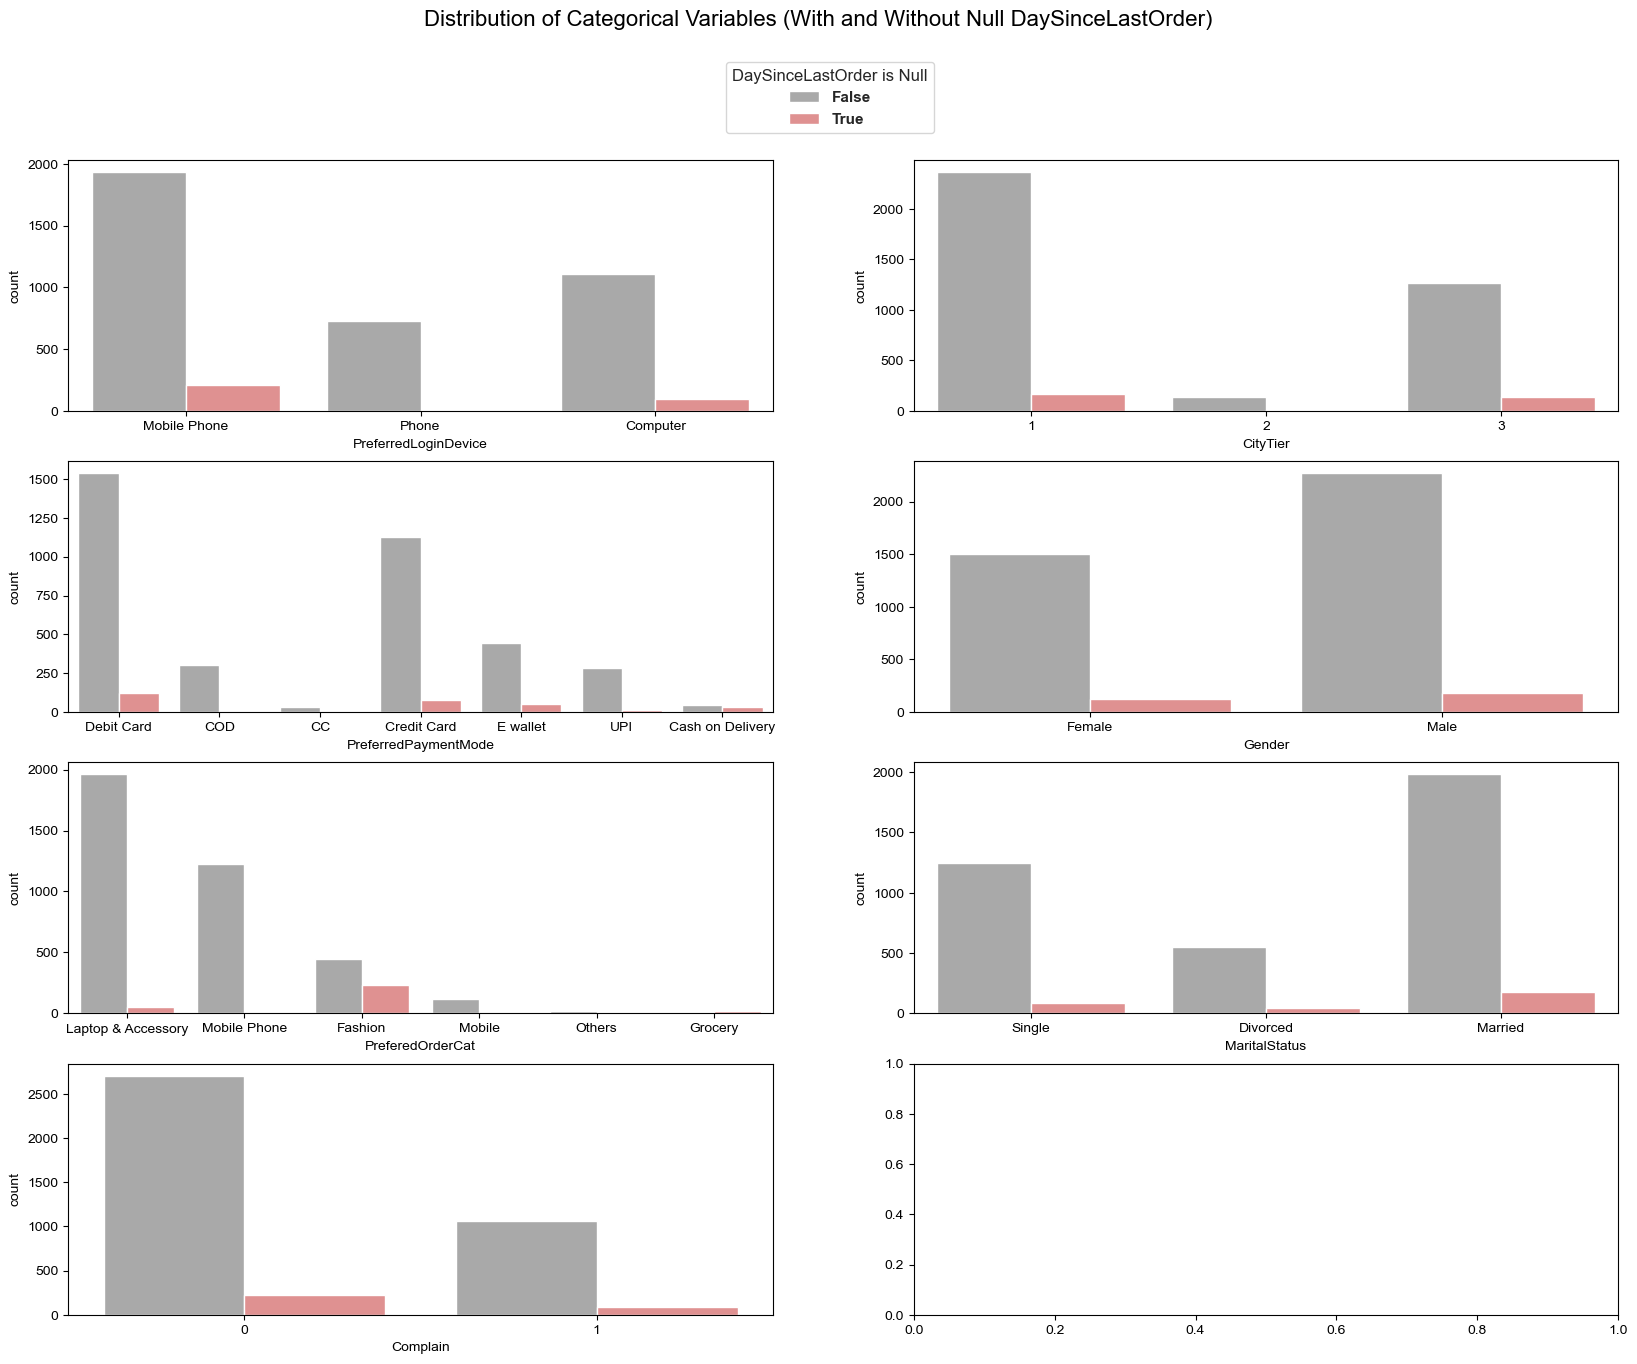

In [28]:
# Reset no_nulls_imp_df
no_nulls_imp_df = df.dropna(subset=df.columns.difference(['DaySinceLastOrder']), inplace=False) # Note this has not been imputed yet, to be imputed
no_nulls_imp_df['NullDaySinceLastOrder'] = no_nulls_imp_df['DaySinceLastOrder'].isnull()
def null_bar_chart_creator(num_cols = 3):

    num_rows = math.ceil(len(categorical_cols)/num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    fig.suptitle('Distribution of Categorical Variables (With and Without Null DaySinceLastOrder)', fontsize=16)
    
    for col, ax in zip(categorical_cols, axes.flatten()):
        col_of_interest = col

        ax.set_title('')
        sns.set(style="whitegrid")
        sns.countplot(data=no_nulls_imp_df, x=col_of_interest, hue='NullDaySinceLastOrder', palette= {False: 'darkgray', True: 'lightcoral'}, saturation = .7, ax=ax, legend=True)
        ax.legend_.remove() #need ax label individually to get one for the overall, so this will hide the individual ones
        ax.grid(False)

    # add overall legend
    handles, labels = axes.flat[0].get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.45, 0.95), title = "DaySinceLastOrder is Null", prop={'weight': 'bold'})
    
    plt.show()
    
null_bar_chart_creator(2)


DaySinceLastOrder being null has the biggest correlation with PreferedOrderCat and PreferredLoginDevice. No observations are null in either of those variables for their respective phone categories. This is likely the cause of the relationships seen. Consequently, NullDaySinceLastOrder has collinearity problems with our data, likely having something to do with mobile phones.

I will still remove the rows with null values for DaySinceLastOrder instead of imputing.

## Modeling

Due to the multicollinearity concerns for 4 features (CashbackAmount, HoursSpendOnApp, OrderAmountHikeFromlastYear, NumberOfDeviceRegistered), the uncertainty over the source of the null values, and the mix of continuous and categorical variables, I will implement tree-based methods. These models are robust to multicollinearity and can handle both types of input variables. More importantly, their ability to handle nulls could be valuable if the nulls are not just a data collection error as most of the observations with nulls were statistically different as already shown. They are also still relatively interpretable model as they can show feature importance. I will not do any feature engineering so that the model maintains interpretability.

To ensure comprehensive coverage given the uncertainty of null value sources, I'll train XGBoost and random forest models on both datasets: one containing null values and the other without.

Additionally, while scaling is helpful for convergence --and can be scaled back to maintain interpretability-- this dataset is only several thousand rows and there will be about 30 features after one-hot-encoding. Consequently, I will not scale the features as the models will still be trained quickly.

I will be using F1 score as the key metric. Although I would lean towards using recall over precision normally for churn, I do not feel that way for this e-commerce business because identifying the most churners is often the goal. I think F1 score is more appropriate here because this e-commerce company offers many deals to boost sales. So, precision is also important so that discounts are not needlessly given to existing customers.

### Encoding

Before doing any feature selection and modeling, I need encode categorical variables. I will do this for both dataframes: the one having no nulls (imp_df) and the one that has nulls (df). I will also use one hot encoding over label encoding because there is no ordinal nature to the variables, and label encoding can cause misinterpretation of variables.

Binary Variables:
- Gender

Multi-Class Variables:
- PreferredLoginDevice
- CityTier
- PreferredPaymentMode
- PreferedOrderCat
- MaritalStatus

In [29]:
# Create training and test data
# Initialize
X_with_nulls = df.drop(columns = ['Churn'], inplace = False)
X_without_nulls = no_nulls_df.drop(columns = 'Churn', inplace = False)
y_with_nulls = df['Churn']
y_without_nulls = no_nulls_df['Churn']

# Drop index to concatenate the categorical and continuous variables later
X_without_nulls.reset_index(drop = True, inplace = True) 
X_with_nulls.reset_index(drop = True, inplace = True)

# Encode categorical columns
    # With Nulls
encoder = OneHotEncoder(drop = 'first', sparse = False)
one_hot_encoded_X = encoder.fit_transform(X_with_nulls[categorical_cols])
one_hot_encoded_X = pd.DataFrame(one_hot_encoded_X, columns = encoder.get_feature_names_out(categorical_cols))
X_with_nulls = pd.concat([X_with_nulls.drop(columns=categorical_cols), one_hot_encoded_X], axis=1)


    # Without Nulls (same procedure as with nulls)
encoder = OneHotEncoder(drop = 'first', sparse = False)
one_hot_encoded_X = encoder.fit_transform(X_without_nulls[categorical_cols])
one_hot_encoded_X = pd.DataFrame(one_hot_encoded_X, columns = encoder.get_feature_names_out(categorical_cols))
X_without_nulls = pd.concat([X_without_nulls.drop(columns=categorical_cols), one_hot_encoded_X], axis=1)


# Split into training and test data
X_with_nulls_train, X_with_nulls_test, y_with_nulls_train, y_with_nulls_test = train_test_split(X_with_nulls, y_with_nulls, random_state = 99, train_size = .6, stratify= y_with_nulls)
X_without_nulls_train, X_without_nulls_test, y_without_nulls_train, y_without_nulls_test = train_test_split(X_without_nulls, y_without_nulls, random_state = 99, train_size = .6, stratify= y_without_nulls)

### Fit Models

In [30]:
# To track results
model_results = pd.DataFrame(columns = ['Model', 'F1 Score', 'Recall'])
def save_model_results(model_name, f1_score, recall):
    global model_results
    new_row = pd.DataFrame({'Model': [model_name], 'F1 Score': [f1_score], 'Recall': [recall]})
    model_results = pd.concat([model_results, new_row], ignore_index=True, axis = 0)

#### Without Nulls Models

##### XGBoost Classifier

In [31]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

# Initialize model and search space
mod_without_nulls = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=99)
param_space = {
    'n_estimators': (100, 1000),   
    'max_depth': (3, 10),          
    'learning_rate': (0.001, 0.2), 
    'min_child_weight': (1,5),
    'gamma': (0, 10)
}

f1_scorer = make_scorer(f1_score)
bayes_search = BayesSearchCV(
    estimator=mod_without_nulls,
    search_spaces=param_space,
    scoring=f1_scorer,
    n_iter=50,         
    cv=7,              
    n_jobs=-1 # -1 means to use all available CPU cores
)
bayes_search.fit(X_without_nulls_train, y_without_nulls_train)

# Results
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", bayes_search.best_score_)

Best Hyperparameters: OrderedDict([('gamma', 0), ('learning_rate', 0.13955863373805652), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 881)])
Best F1 Score: 0.848633848668246


In [32]:
# Train the model using the best parameters found above
xgb_mod_without_nulls = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric='logloss', seed = 99, **best_params)
xgb_mod_without_nulls.fit(X_without_nulls_train, y_without_nulls_train)

y_pred = xgb_mod_without_nulls.predict(X_without_nulls_test)
f1_score_test = f1_score(y_without_nulls_test, y_pred)
recall_score_test = recall_score(y_without_nulls_test, y_pred)
print(f"F1 Score on Test Data: {f1_score_test}")
print(f"Recall Score on Test Data: {recall_score_test}")
save_model_results("xgb_mod_without_nulls", f1_score_test, recall_score_test)

F1 Score on Test Data: 0.8747433264887063
Recall Score on Test Data: 0.8452380952380952


##### Random Forest Classifier

In [33]:
# Initialize model and search space
mod_without_nulls = RandomForestClassifier(random_state=99)
param_space = {
    'n_estimators': (100, 1000),   
    'max_depth': (3, 10),          
    'min_samples_split': (5, 20),
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

f1_scorer = make_scorer(f1_score)
bayes_search = BayesSearchCV(
    estimator=mod_without_nulls,
    search_spaces=param_space,
    scoring=f1_scorer,
    n_iter=50,         
    cv=7,              
    n_jobs=-1 # -1 means to use all available CPU cores
)
bayes_search.fit(X_without_nulls_train, y_without_nulls_train)

# Results
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", bayes_search.best_score_)

Best Hyperparameters: OrderedDict([('class_weight', 'balanced_subsample'), ('max_depth', 9), ('min_samples_split', 5), ('n_estimators', 100)])
Best F1 Score: 0.7829517689204682


In [34]:
# Train the model using the best parameters found above
rf_mod_without_nulls = RandomForestClassifier(random_state = 99, **best_params)
rf_mod_without_nulls.fit(X_without_nulls_train, y_without_nulls_train)

y_pred = rf_mod_without_nulls.predict(X_without_nulls_test)
f1_score_test = f1_score(y_without_nulls_test, y_pred)
recall_score_test = recall_score(y_without_nulls_test, y_pred)
print(f"F1 Score on Test Data: {f1_score_test}")
print(f"Recall Score on Test Data: {recall_score_test}")
save_model_results("rf_mod_without_nulls", f1_score_test, recall_score_test)

F1 Score on Test Data: 0.783132530120482
Recall Score on Test Data: 0.7738095238095238


#### With Nulls Models

##### XGBoost Classifier

In [35]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

# Initialize model and search space
mod_with_nulls = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=0)
param_space = {
    'n_estimators': (100, 1000),   
    'max_depth': (3, 10),          
    'learning_rate': (0.001, 0.2), 
    'min_child_weight': (1,5),
    'gamma': (0, 10)
}

f1_scorer = make_scorer(f1_score)
bayes_search = BayesSearchCV(
    estimator=mod_with_nulls,
    search_spaces=param_space,
    scoring=f1_scorer,
    n_iter=50,         
    cv=7,              
    n_jobs=-1 # -1 means to use all available CPU cores
)
bayes_search.fit(X_with_nulls_train, y_with_nulls_train)

# Results
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", bayes_search.best_score_)

Best Hyperparameters: OrderedDict([('gamma', 0), ('learning_rate', 0.186579051329371), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 968)])
Best F1 Score: 0.8479137982840671


In [36]:
# Train the model using the best parameters found above
xgb_mod_with_nulls = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric='logloss', seed = 0, **best_params)
xgb_mod_with_nulls.fit(X_with_nulls_train, y_with_nulls_train)

y_pred = xgb_mod_with_nulls.predict(X_with_nulls_test)
f1_score_test = f1_score(y_with_nulls_test, y_pred)
recall_score_test = recall_score(y_with_nulls_test, y_pred)
print(f"F1 Score on Test Data: {f1_score_test}")
print(f"Recall Score on Test Data: {recall_score_test}")
save_model_results("xgb_mod_with_nulls", f1_score_test, recall_score_test)

F1 Score on Test Data: 0.8615384615384615
Recall Score on Test Data: 0.8126649076517151


##### Random Forest Classifier

In [37]:
# RandomForestClassifier cannot natively handle nulls so I will impute -9999 for the nulls as that value will never occur in this dataset where there are no negative values otherwise
preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=-9999)
)
X_with_nulls_train_preprocessed = preprocessor.fit_transform(X_with_nulls_train)
X_with_nulls_test_preprocessed = preprocessor.transform(X_with_nulls_test)

# Initialize model and search space
mod_without_nulls = RandomForestClassifier(random_state=99)
param_space = {
    'n_estimators': (100, 1000),   
    'max_depth': (3, 10),          
    'min_samples_split': (5, 20),
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

f1_scorer = make_scorer(f1_score)
bayes_search = BayesSearchCV(
    estimator=mod_without_nulls,
    search_spaces=param_space,
    scoring=f1_scorer,
    n_iter=50,         
    cv=7,              
    n_jobs=-1 # -1 means to use all available CPU cores
)
bayes_search.fit(X_with_nulls_train_preprocessed, y_with_nulls_train)

# Results
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", bayes_search.best_score_)

Best Hyperparameters: OrderedDict([('class_weight', 'balanced'), ('max_depth', 10), ('min_samples_split', 5), ('n_estimators', 945)])
Best F1 Score: 0.7840200127810805


In [38]:
# Train the model using the best parameters found above
rf_mod_with_nulls = RandomForestClassifier(random_state = 99, **best_params)
rf_mod_with_nulls.fit(X_with_nulls_train_preprocessed, y_with_nulls_train)

y_pred = rf_mod_with_nulls.predict(X_with_nulls_test_preprocessed)
f1_score_test = f1_score(y_with_nulls_test, y_pred)
recall_score_test = recall_score(y_with_nulls_test, y_pred)
print(f"F1 Score on Test Data: {f1_score_test}")
print(f"Recall Score on Test Data: {recall_score_test}")
save_model_results("rf_mod_with_nulls", f1_score_test, recall_score_test)

F1 Score on Test Data: 0.7688243064729194
Recall Score on Test Data: 0.7678100263852242


## Results

In [39]:
model_results['Has Nulls'] = model_results['Model'].str.contains('with_nulls').astype(int)
model_results.head()

,Model,F1 Score,Recall,Has Nulls
0,xgb_mod_without_nulls,0.874743,0.845238,0
1,rf_mod_without_nulls,0.783133,0.773810,0
2,xgb_mod_with_nulls,0.861538,0.812665,1
3,rf_mod_with_nulls,0.768824,0.767810,1


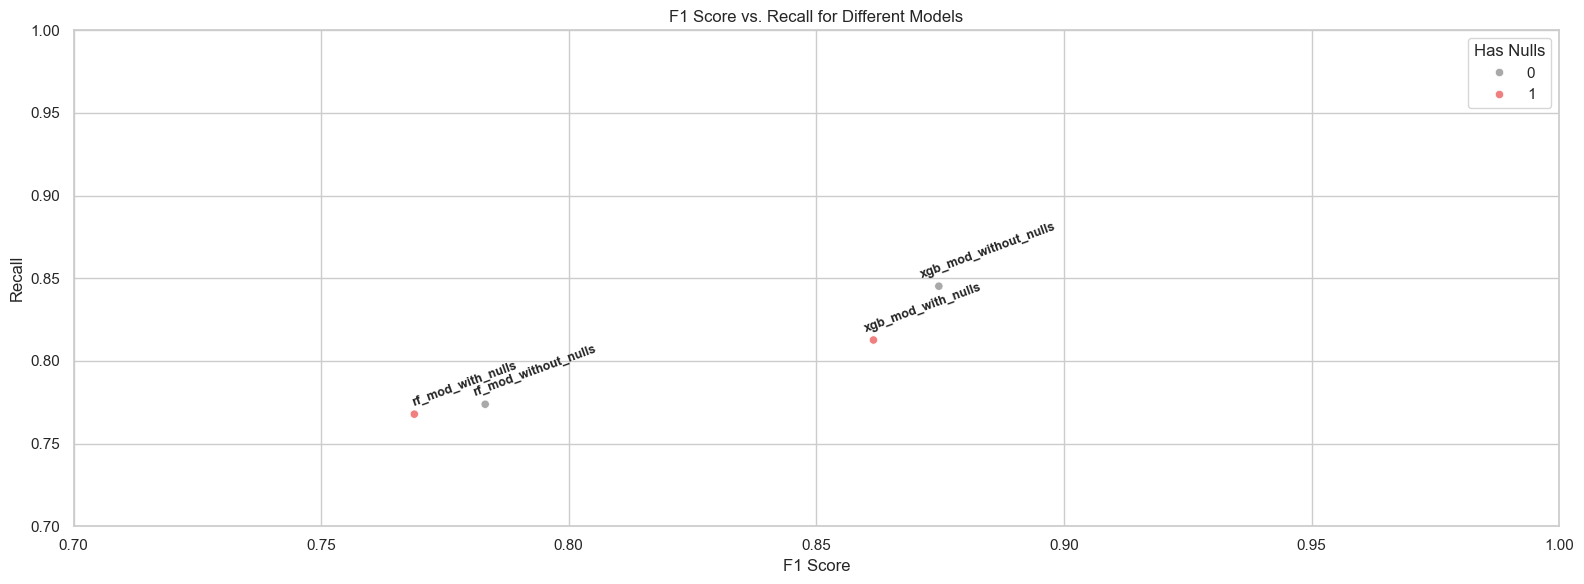

In [48]:
palette = {1: 'lightcoral', 0: 'darkgray'}
plt.figure(figsize=(16,6))
sns.scatterplot(data=model_results, x='F1 Score', y='Recall', hue = 'Has Nulls', palette = palette)
plt.title('F1 Score vs. Recall for Different Models')
plt.xlabel('F1 Score')
plt.ylabel('Recall')
plt.xlim(0.7, 1)
plt.ylim(0.7, 1)

# Put model names on graph
for i, row in model_results.iterrows():
    plt.text(row['F1 Score']+.01, row['Recall'] + .005, row['Model'], fontsize=9, ha='center', weight = 'bold', rotation = 20)
    
plt.tight_layout()
plt.show()

The XGBoost models outperformed random forests for both the null-having and no-nulls datasets, so it is the preferred model. F1 and recall scores in the .80s are a great result for stakeholders as that means they can have confidence when applying treatments to prevent customer churn.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

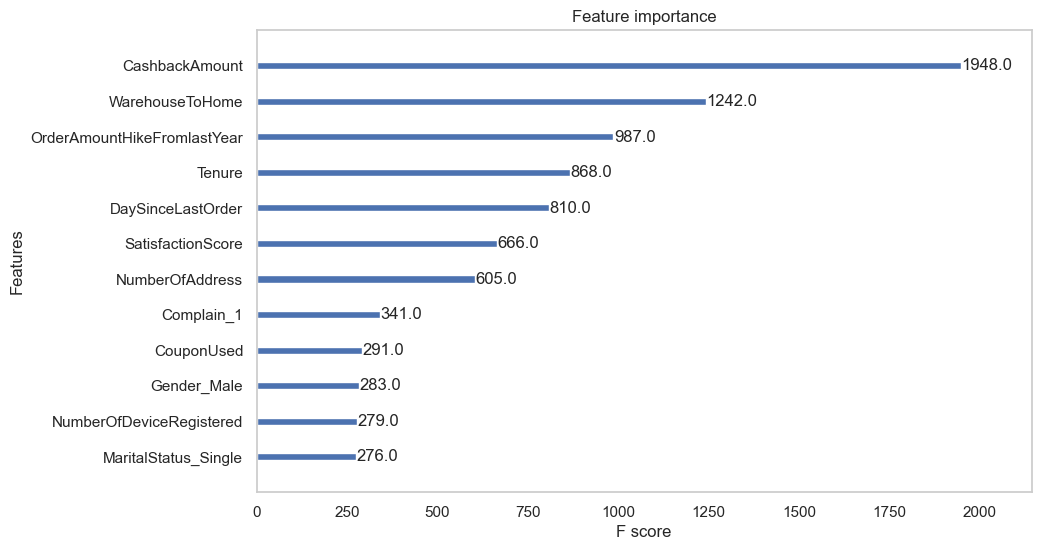

In [41]:
plt.rcParams['figure.figsize'] = (10, 6)
xgb.plot_importance(xgb_mod_without_nulls, grid = False, max_num_features=12) # Top 10 most important features

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

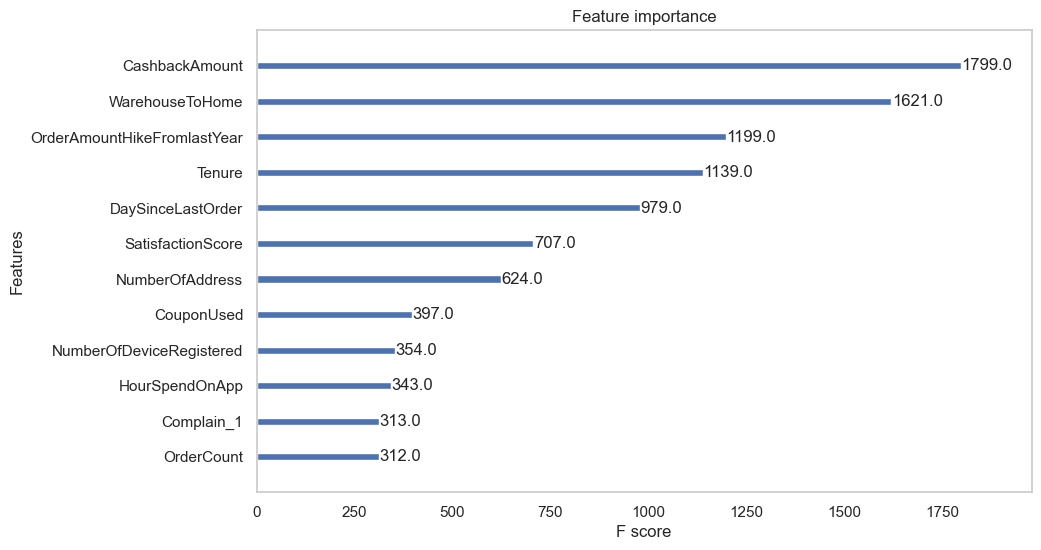

In [42]:
plt.rcParams['figure.figsize'] = (10, 6)
xgb.plot_importance(xgb_mod_with_nulls, grid = False, max_num_features=12) # Top 10 most important features

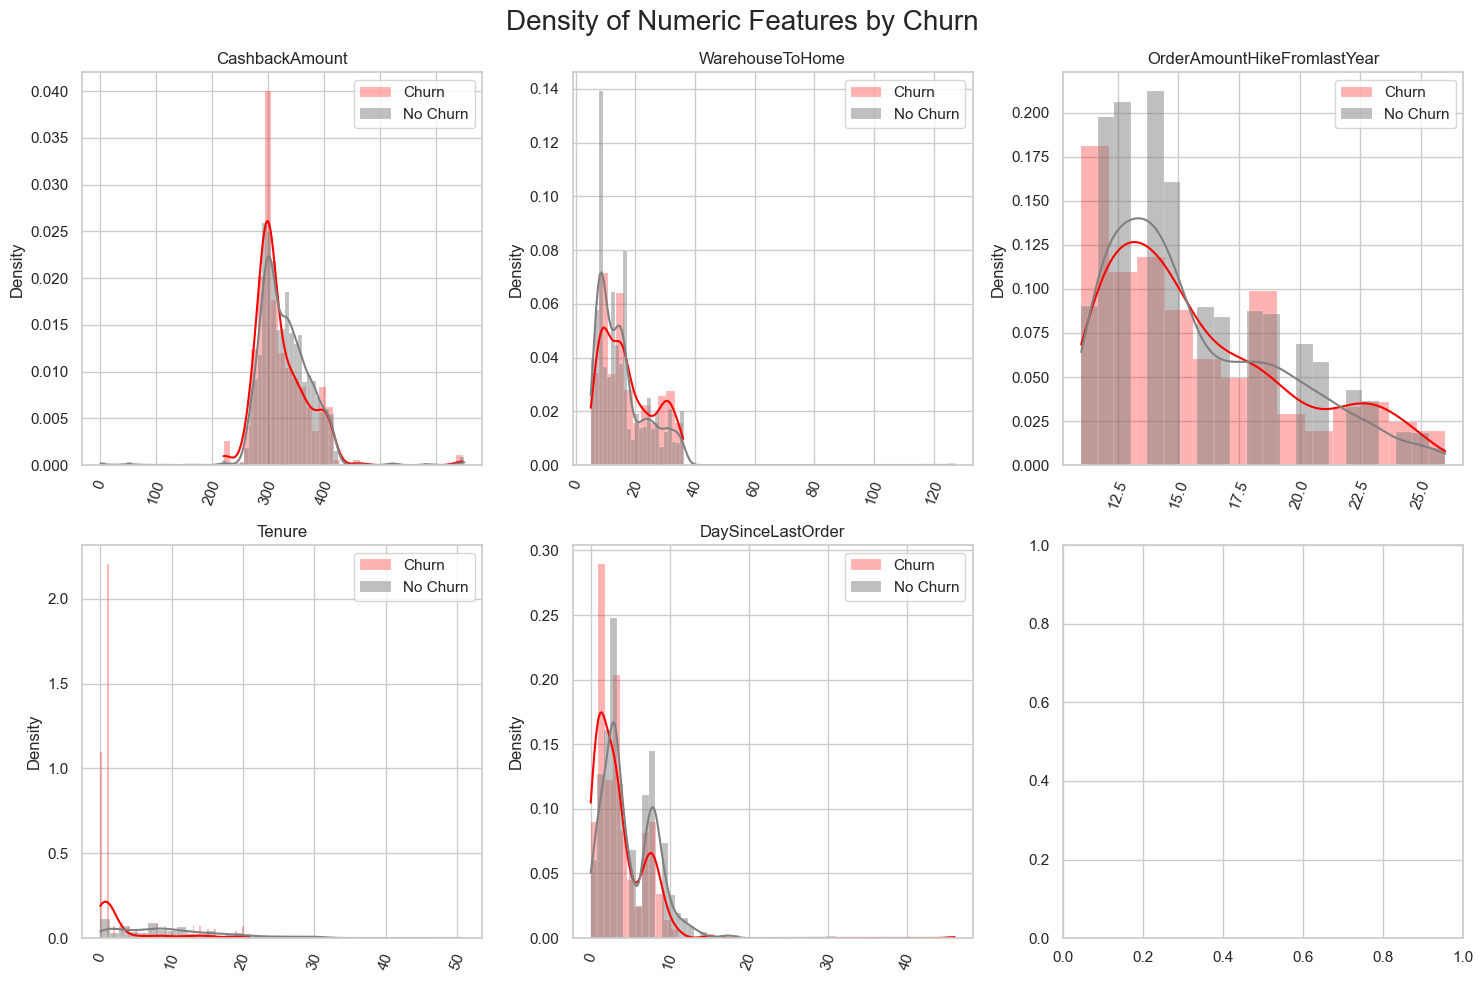

In [51]:
top_5 = ['CashbackAmount', 'WarehouseToHome', 'OrderAmountHikeFromlastYear', 'Tenure', 'DaySinceLastOrder']

plot_stacked_histograms(no_nulls_df, top_5, 3, True)

The most important features are similar between the two datasets for XGBoost. The most important features were similar for both, with the top 10 being the same top 10, and the top 5 being in the same order.

The relationship with churn for the top 5 most important features, in order of importance:
- **Cashback amount**: More cashback has more churn
- **Warehouse to Home**: Further distance has more churn
- **Order Amount Hike from Last Year**: Lower order Hike had less churn
- **Tenure**: Lower tenure has more churn
- **Days Since Last Order**: Less time since last order has more churn

I have two suggestions for stakeholders.

My first suggestion would be to uncover where the null data points are coming from. The null groups were statistically different; though the models still performed similarly despite this, more patterns could be uncovered if the reason that the nulls exist is uncovered. *This could also improve the model's performance.*

I would also suggest that the company further analyze its marketing efforts because days since the last order negatively correlate with churn. This is counterintuitive. One would expect customers who have ordered more recently to be more loyal --but that is not the case here. I suspect that there was recently a marketing campaign or some promotion that brought on customers. This is further supported by the fact that the cashback amount was the most important feature, and more cashback had more churn. So, I presume there was recently been a cashback campaign for purchases. 

For further analysis, in addition to diagnosing the source of the nulls, I would recommend doing more feature engineering, assuming prediction is the goal. I would also recommend including flags for promotions or campaigns for customers to control for that as that appears to be what drove the models in this project.